# Author: Lukas Delaye
## Goal: Visualize the electric field impact of a probe at the Lyot plane to check for vignetting.
Here is a test with gaussian


In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import yaml
import proper # Required for manual propagation
from corgihowfsc.utils.corgisim_manager import CorgisimManager
from howfsc.model.mode import CoronagraphMode
from howfsc.control.cs import ControlStrategy
from howfsc.util.loadyaml import loadyaml
import roman_preflight_proper
if not os.path.exists('roman_preflight.py'):
    print("Copie de la prescription roman_preflight.py dans le dossier courant...")
    roman_preflight_proper.copy_here()

In [2]:
# Configs of paths
# CHANGE THE ROOT FOR YOUR LAPTOP :)
repo_root = "C:/Users/ldelaye/Documents/Repos/corgihowfsc"
model_root = os.path.join(repo_root, "corgihowfsc", "model")
nfov_dir = os.path.join(model_root, "nfov_band1", "nfov_band1_360deg")
probes_dir = os.path.join(model_root, "probes")

# Config files
yaml_file = os.path.join(nfov_dir, "howfsc_optical_model.yaml")
hconf_file = os.path.join(model_root, "nfov_band1", "hconf_nfov_flat.yaml")
cstrat_file = os.path.join(nfov_dir, "cstrat_nfov_band1.yaml")

# Probe file to analyze
probe_filename = 'nfov_dm_dmrel_4_1.0e-05_cos.fits'
probe_file = os.path.join(probes_dir, probe_filename)

## Load the entire optical prescription for the Roman telescope (pupil, mirrors, DMs, FPM) with the FULL MODEL
#### Notice : Using is_noise_free: True is perfect. For this diagnosis, we want to see the pure physics of diffraction, without photon or readout noise that would cloud the analysis.

In [3]:
# Inits
print("Initializing configuration objects...")
cfg = CoronagraphMode(yaml_file)          # Optical layout
cstrat = ControlStrategy(cstrat_file)     # Control parameters
hconf = loadyaml(hconf_file, custom_exception=TypeError) # Star props

# Initialize CorgisimManager (The Full Optical Model wrapper)
overrides = {
    'bandpass': '1',
    'is_noise_free': True,
    'output_dim': 153
}
manager = CorgisimManager(cfg, cstrat, hconf, cor='nfov_flat', corgi_overrides=overrides)
print("CorgisimManager ready.")

Initializing configuration objects...
Adding 0 off-axis sources
CorgisimManager ready.


In [4]:
# DM and probes setup
try:
    probe_map = fits.getdata(probe_file)
    print(f"Probe loaded. Shape: {probe_map.shape}")
except FileNotFoundError:
    print(f"Error: Probe file not found. Using zero map.")
    probe_map = np.zeros((48, 48))

# Define DM commands
# dm1_probe = Flat map + Probe perturbation
dm1_flat = np.zeros(probe_map.shape)
dm1_probe = dm1_flat + probe_map
dm2_flat = np.zeros(probe_map.shape)

Probe loaded. Shape: (48, 48)


## Instead of letting the simulator go all the way to the detector (which is what get_image does by default), we want to force the propagation engine (PROPER) to stop immediately after the Lyot Stop plane via the end_at_lyot_stop flag.
#### Notice : I calculate the total field with the probe, and subtract the reference field (without probe) to see only the effect off the probes.

In [5]:
# Propatation to Lyot functions
def get_lyot_plane_field(mgr, dm1_v, dm2_v):
    """
    Propagates the wavefront through the optical system up to the Lyot Stop.
    Uses proper.prop_run_multi manually to bypass CorgiOptics restrictions.
    """
    # Create corgi object
    optics = mgr.create_optics(dm1_v, dm2_v, lind=0)

    # Retrieve the good keyword
    passvalue = optics.optics_keywords.copy()
    passvalue['end_at_lyot_stop'] = 1
    passvalue['use_lyot_stop'] = 1

    # Run PROPER manually
    try:
        (fields, sampling) = proper.prop_run_multi(
            'roman_preflight',
            optics.lam_um,
            1024, # Grid size (Pupil usually ~1000 pix)
            PASSVALUE=passvalue,
            QUIET=True
        )

        # Fields is an array of shape (n_wavelengths, ny, nx): we return the field for the first wavelength
        return fields[0]

    except Exception as e:
        print(f"Error during PROPER propagation: {e}")
        return np.zeros((1024, 1024), dtype=complex)

print("Computing Reference Field (Flat DM)...")
E_ref = get_lyot_plane_field(manager, dm1_flat, dm2_flat)

print("Computing Probed Field (Probe DM)...")
E_probe = get_lyot_plane_field(manager, dm1_probe, dm2_flat)

# Differential field (The E-field vector added by the probe)
Delta_E = E_probe - E_ref

Computing Reference Field (Flat DM)...
CorgiOptics initialized with proper keywords.
Computing Probed Field (Probe DM)...
CorgiOptics initialized with proper keywords.


Loading Lyot Stop FITS from: C:\Users\ldelaye\Documents\Repos\corgihowfsc\corgihowfsc\model\nfov_band1\any\lyot_amp.fits
Note: Resizing Lyot mask for display ((340, 340) -> (153, 153))


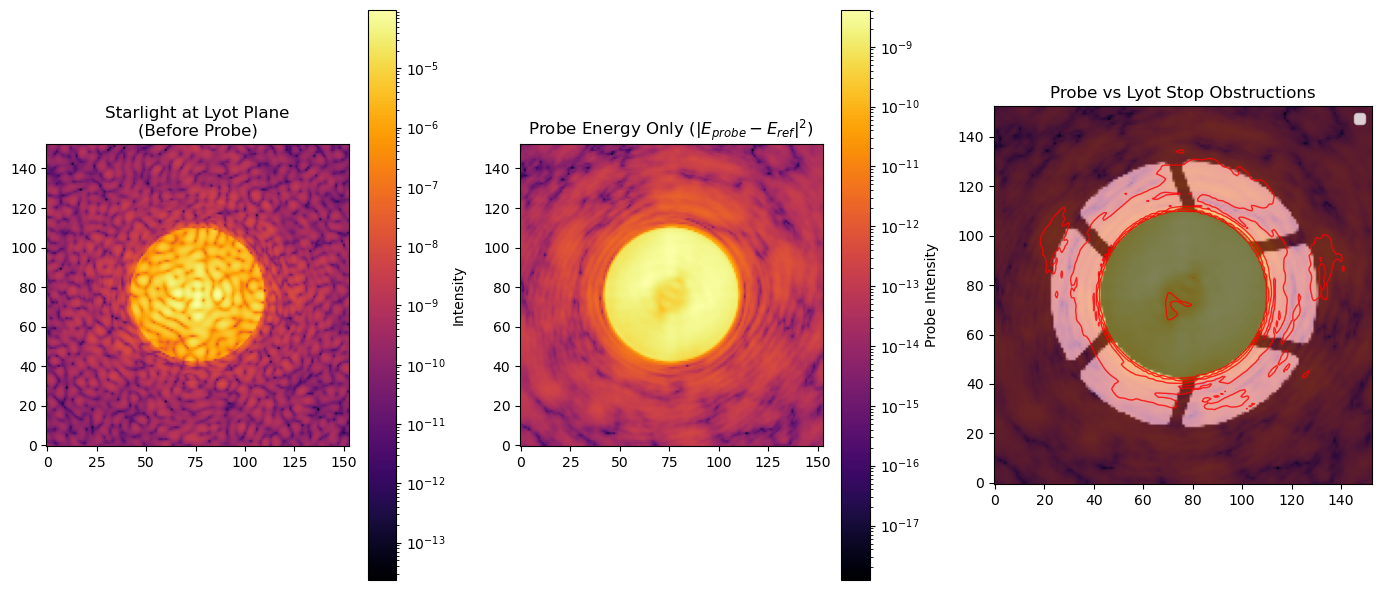

In [6]:
# Load Lyot stop
from scipy.ndimage import zoom

with open(yaml_file, 'r') as f:
    raw_cfg = yaml.safe_load(f)

lyot_rel_path = raw_cfg['sls'][0]['lyot']['afn']
lyot_path = os.path.normpath(os.path.join(nfov_dir, lyot_rel_path))

print(f"Loading Lyot Stop FITS from: {lyot_path}")
lyot_mask_fits = fits.getdata(lyot_path)

# Plotting
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.title("Starlight at Lyot Plane\n(Before Probe)")
plt.imshow(np.abs(E_ref)**2, origin='lower', cmap='inferno', norm=LogNorm())
plt.colorbar(label="Intensity")

probe_intensity = np.abs(Delta_E)**2
plt.subplot(1, 3, 2)
plt.title(r"Probe Energy Only $(|E_{probe} - E_{ref}|^2)$")
plt.imshow(probe_intensity, origin='lower', cmap='inferno', norm=LogNorm())
plt.colorbar(label="Probe Intensity")

plt.subplot(1, 3, 3)
plt.title("Probe vs Lyot Stop Obstructions")

if lyot_mask_fits.shape != probe_intensity.shape:
    print(f"Note: Resizing Lyot mask for display ({lyot_mask_fits.shape} -> {probe_intensity.shape})")
    zoom_factor = probe_intensity.shape[0] / lyot_mask_fits.shape[0]
    lyot_mask_resized = zoom(lyot_mask_fits, zoom_factor, order=0)
else:
    lyot_mask_resized = lyot_mask_fits

plt.imshow(lyot_mask_resized, origin='lower', cmap='grey', alpha=1.0, label='Lyot Stop')

if probe_intensity.max() > 0:
    plt.contour(probe_intensity, levels=np.logspace(np.log10(probe_intensity.max())-4, np.log10(probe_intensity.max()), 5),
                colors='red', linewidths=1, alpha=0.8)

plt.imshow(probe_intensity, origin='lower', cmap='inferno', norm=LogNorm(), alpha=0.5)

plt.legend(["Red Contours: Probe Energy"], loc='upper right')
plt.tight_layout()
plt.show()

## Interpretation of the final plot:

#### If the red contours (probe energy) fall on the gray/black areas (blocking areas of the mask), this means that the probe is vignetted.

#### If it is vignetted, the compact model (which assumes perfect or linear transmission) will be incorrect, and the wavefront estimate will be biased.